# Bias structure of sWBGT and ESI within an idealized setting

- This notebook aims to quantify biases of simplified WBGT (sWBGT) and environmental stress index (ESI) by comparing against Liljegren et al. (2008)'s explicit formulation of WBGT. 

- We will explore the bias structure of sWBGT and ESI as a function of air temperature, humidity, wind speed and solar radiation within an idealized setting, which can serve as a guidance for further detailed bias assessment or practical applications.

- In this notebook, we will reproduce Figure 1 in "Explicit Calculations of Wet Bulb Globe Temperature compared with approximations and why it matters for labor productivity" by Qinqin Kong and Matthew Huber. 

- Here we use Liljegren's original formulation in which surface downward solar radiation is the only required radiation input and other radiation components (surface reflected solar radiation, and surface downward and upwelling thermal radiation) are approximated. But all other Figures are generated using our modified formulation which directly takes the full set of radition components (available in ERA5 reanalysis data) as inputs.

In [7]:
import xarray as xr
import numpy as np
from numba import vectorize
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmaps
from WBGT import WBGT_Liljegren, fdir

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Select artifical ranges of air temperature, relative humidity, wind speed, and solar radiation
- We first make some articial ranges of air temperature, relative humidity, wind speed, and solar radiation across which we will explore the distribution of biases of sWBGT and ESI.

- The range was selected with the aim to cover relevant heat stress levels in the modern world or future projections under warming scenarios.

In [3]:
# air temperature: 20-50 C with a step of 2 C
tas=np.arange(50.,18.,-2)
# relative humidity: 5% to 95% with a step of 5%
hurs=np.arange(5.,100.,5)
# wind speed: 0.13, 0.5, 1, 2, 3 m/s
wind=np.array([0.13, 0.5, 1, 2, 3])
# surface downward solar radiation: 900w, 700, 500, 300, 0 w/m2
rsds=np.array([0., 300., 500., 700., 900.])

### Functions to calculate WBGT
Define functions to calculate WBGT, ESI, and sWBGT across selected ranges of inputs. The function will also arange the calculated values into a 2D array that can be directly used for plotting.

In [8]:
# calculate saturation vapor pressure
def esat(tas):
    # tas: temperature (K)
    # return saturation vapor pressure in Pa
    return 611.2*np.exp(17.67*(tas-273.15)*((tas-273.15+243.5)**(-1)))
# calculate ESI
def ESI(tas,hurs,rsds):
    # tas: temperature (K)
    # hurs: relative humidity (%)
    # rsds: surface downward solar radiation (w/m2)
    # return ESI (K)
    return 0.62*(tas-273.15)-0.007*hurs+0.002*rsds+0.0043*((tas-273.15)*hurs)-0.078*((0.1+rsds)**(-1))+273.15
# calculate sWBGT
def SWBGT(tas, hurs):
    # tas: temperature (K)
    # hurs: relative humidity (%)
    # return sWBGT (K)
    return 0.567*(tas-273.15)  + 0.393*esat(tas)*(hurs*0.01)/100 + 3.94 + 273.15

# calculate three metrics (WBGT and sWBGT in K, and ESI in C) across selected ranges of inputs and arrange it in the way we want
def cal_metric(tas,hurs,wind,rsds,metric):
    hurs2,tas2=np.meshgrid(hurs, tas)
    RESULT=np.zeros((len(tas)*len(wind),1))
    for r in rsds:
        result=np.zeros(hurs.shape)
        for w in wind:
            if metric=='sWBGT':
                tmp=SWBGT(tas2,hurs2) # calculate sWBGT
            elif metric=='ESI':
                tmp=ESI(tas2,hurs2,r) # calculate ESI
            else:
                # assign a random date which is only used for calculating sun-earth distance
                # different dates will only make a very slight difference
                date=np.array([np.datetime64('2019-07-01T12:00:00')])
                
                # assign the cosine zenith angle as 0.7 (other values won't affect our results qualitatively)
                # we let cosz have the same shape as air temperature which is required by our function
                cosz=0.7+tas2*0
                
                # expand surface pressure, solar radiation and wind speed to the same shape as temperature
                solar=r+tas2*0 
                windspeed=w+tas2*0
                ps=100000.+tas2*0 # assume 1000hPa surface pressure
                
                # calculate ratio of direct solar radiation
                f=fdir(cosz,cosz,solar,date) 
                # calculate WBGT; the boolean value 'True' tell the function we are using wind speed at 2m height
                # If we pass in 'False', the function will assume wind speed is measured at 10m height and will transfer
                # it to 2m wind internally.
                tmp=WBGT_Liljegren(tas2,hurs2,ps,windspeed,solar,f,cosz,True) 
            result=np.vstack((result,tmp))
        RESULT=np.hstack((RESULT,result[1:,:]))
    return RESULT[:,1:]

### Calculate three metrics

In [18]:
swbgt=cal_metric(tas+273.15,hurs,wind,rsds,'sWBGT')-273.15
esi=cal_metric(tas+273.15,hurs,wind,rsds,'ESI')-273.15
wbgt=cal_metric(tas+273.15,hurs,wind,rsds,'WBGT')-273.15

### Plot
Next, let's make a plot of the biases as a function of air temperature, relative humidity, wind speed and solar radiation

In [29]:
# function to plot each individual subplot
def subplot(data,axis,cmap,norm,ylabel):
    # ylabel is a boolean value that controls whether we want to plot the label on y-axis
    g=axis.imshow(data,cmap=cmap,norm=norm) # make the plot
    for i in np.arange(18,94,19):
        axis.axvline(x=i+0.5,linewidth=1, color='grey') # draw vertical lines
    for j in np.arange(15,79,16):
        axis.axhline(y=j+0.5,linewidth=1, color='grey') # draw horizontal lines
    axis.set_xticks(np.arange(10,90,19)) # control where to add ticks
    axis.set_xticklabels(["0","300","500","700","900"],fontsize=12) # set tick labels
    axis.set_xlabel('solar radiation (W/m$^2$)',fontsize=14) # set label for x-axis
    if ylabel:
        axis.set_yticks(np.arange(7,80,16)) # control where to add ticks
        axis.set_yticklabels(["0.13","0.5","1.0","2.0","3.0"],fontsize=12) # set tick labels
        axis.set_ylabel('wind speed (m/s)',fontsize=14) # # set label for x-axis
    else:
        axis.set_yticks([]) # turn off ticks on y-axis
        axis.set_ylabel('') # turn off labels on y-axis
    return g

# function to make the whole plot
def plot(swbgt_biases,esi_biases):
    # we pick colors from two colormaps, create a new color list, and then create a customized colormap from this new color list
    color1=cmaps.GMT_polar.colors
    color2=cmaps.temp_diff_18lev.colors
    color_new=np.concatenate((color1[0:10],np.atleast_2d(color2[9]),color1[10:]))
    cmap=mpl.colors.ListedColormap(color_new)
    
    # set the colorbar scale
    levels = [-10, -9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10]
    norm=mpl.colors.BoundaryNorm(levels,ncolors=len(levels)+1,extend='both')
    
    # create a figure
    fig=plt.figure(constrained_layout=False,figsize=(20,8)) # create a figure
    # use gridspec to customize the relative size of subplots
    spec = gridspec.GridSpec(ncols=3, nrows=2,width_ratios=[2,2,1], wspace=-0.05, height_ratios=[1, 1])
    # add three axis
    ax1 = fig.add_subplot(spec[0:4])
    ax2 = fig.add_subplot(spec[1:5])
    ax3 = fig.add_subplot(spec[5])
    
    # add annotates for each axis
    anno_opts1 = dict(xy=(-0.1, 1.05), xycoords='axes fraction',va='center', ha='center')
    anno_opts2 = dict(xy=(-0.02, 1.05), xycoords='axes fraction',va='center', ha='center')
    anno_opts3 = dict(xy=(-0.02, 1.1), xycoords='axes fraction',va='center', ha='center')
    ax1.annotate('a', **anno_opts1,fontsize=16)
    ax2.annotate('b', **anno_opts2,fontsize=16)
    ax3.annotate('c', **anno_opts3,fontsize=16)
    
    # call subplot function
    g=subplot(swbgt_biases,ax1,cmap,norm,True) # plot swbgt biases
    subplot(esi_biases,ax2,cmap,norm,False) # plot esi biases
    
    # The two subplots above contain 5x5 small boxes with each small box depicting the bias distribution as a function 
    # of air temperature (y-axis) and relative humidity (x-axis) at fixed level of solar radiation and wind speed.
    
    # Here we choose a subsample of sWBGT biases corresponding to a certain fixed level of solar radiation and wind speed to show
    # the distribution of biases as a function of temperature and wind.
    sample=swbgt_biases[32:48,38:57]
    X,Y=np.meshgrid(hurs,tas)
    ax3.pcolormesh(X,Y,sample,cmap=cmap,norm=norm)
    ax3.set_xticks(np.arange(10,100,10))
    ax3.set_yticks(np.arange(50,20,-5))
    ax3.set_xticklabels(np.arange(10,100,10),fontsize=12)
    ax3.set_yticklabels(np.arange(50,20,-5),fontsize=12)
    # plot y-axis ticks and labels on the right side
    ax3.yaxis.set_ticks_position("right")
    ax3.yaxis.set_label_position("right")
    # add label for both x and y axis
    ax3.set_xlabel('relative humidity (%)',fontsize=14)
    ax3.set_ylabel('temperature ($^\circ$C)',fontsize=14)
    
    # plot colorbar
    cb=fig.colorbar(g, ax=(ax1,ax2,ax3),pad=0.15,shrink=0.6,orientation='horizontal',
                    ticks=levels,aspect=30,spacing='proportional')
    cb.set_label(label='sWBGT/ESI - WBGT ($^\circ$C)',size=14)
    cb.ax.tick_params(labelsize=12)

<ipython-input-29-1237eb961002>:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax3.pcolormesh(X,Y,sample,cmap=cmap,norm=norm)


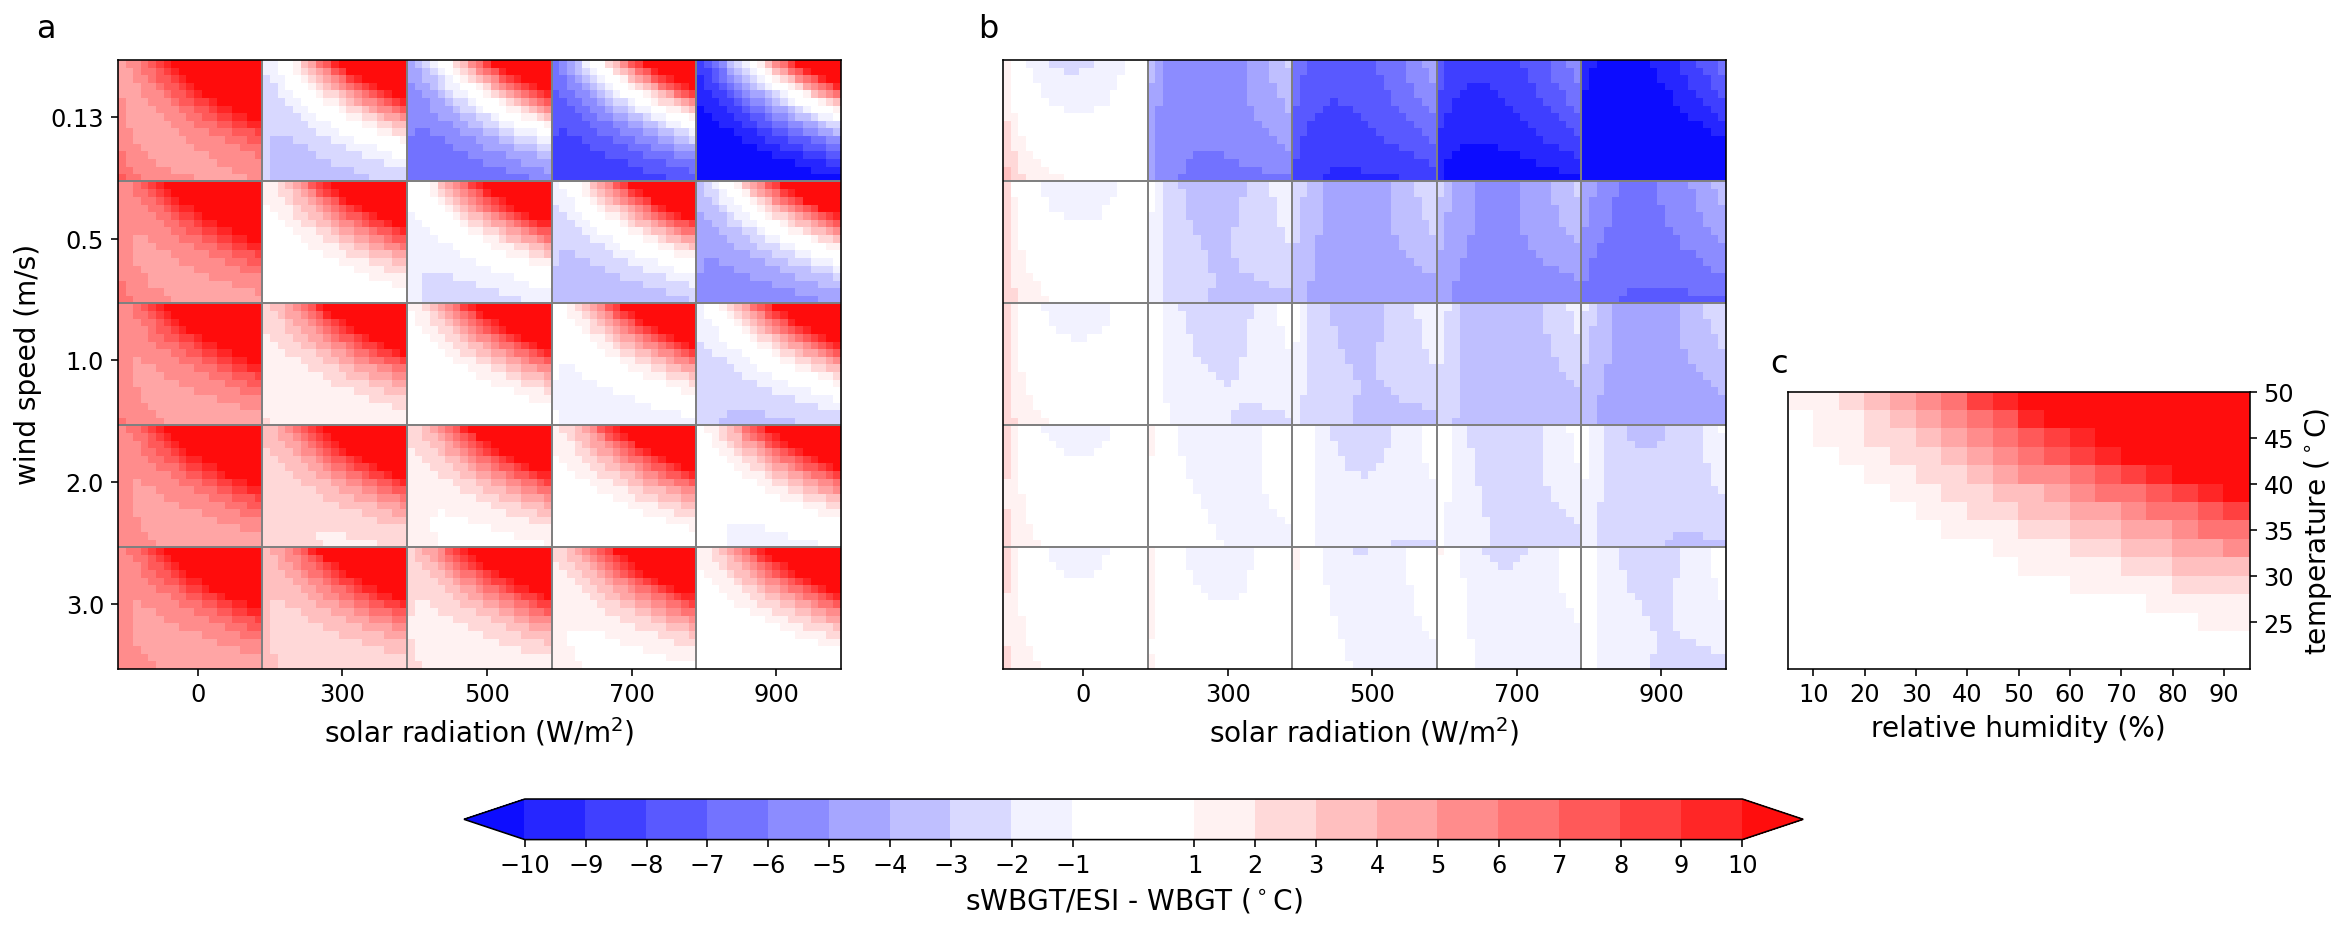

In [30]:
plot(swbgt-wbgt,esi-wbgt)

# Figure caption:
Bias distribution of sWBGT (a) and ESI (b) across an artificial 4-D climatic space of air temperature, relative humidity, 2m wind speed and surface downward solar radiation. Each small box in (a) and (b) depicts bias distribution across a range of temperature (20-50\textdegree{}C) and relative humidity (5-95\%) as shown in (c) under fixed levels of solar radiation and wind speed.

# Findings
- In the case of sWBGT, positive biases (sWBGT > WBGT) appear to be dominant, especially during nighttime (zero solar radiation), with bias magnitudes up to more than +10°C. Nevertheless, negative biases (sWBGT < WBGT) may occur under strong solar radiation and light wind condition. Given any fixed level of solar radiation and wind speed, there tends to be larger positive biases under hotter and more humid condition which is a direct result of sWBGT placing all weights on temperature and humidity. 

- ESI is mainly subject to negative biases. Wind speed and solar radiation appear to be the dominant factors controlling bias magnitudes with larger negative biases under strong solar radiation and light wind (up to -10 °C under 900w$\cdot m^{-2}$ solar radiation and 0.13 m/s wind speed). Under dry condition with relative humidity <10%, ESI exhibits smaller negative biases and even positive ones during nighttime when the bias magnitudes are overall smaller as well.

- The results here provide an overall picture of sWBGT/ESI biases across the 4-D climatic space which can serve as a guidance for further detailed bias assessment or practical applications. For example, we expect larger over-estimations by sWBGT during nighttime (or indoor) or under hot-humid climate such as in the tropics, and larger under-estimation by ESI under sunny, calm days.

# Reference:
Liljegren, J. C., Carhart, R. A., Lawday, P., Tschopp, S. & Sharp, R. Modeling the Wet Bulb Globe Temperature Using Standard Meteorological Measurements. Journal of Occupational and Environmental Hygiene 5, 645–655 (2008).
